# Dot plots of ephys features

In [1]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import matplotlib
import pickle
import scipy
import time
import warnings

def sns_styleset():
    sns.set(context='paper', style='ticks', font='DejaVu Sans')
    matplotlib.rcParams['axes.linewidth']    = .5
    matplotlib.rcParams['xtick.major.width'] = .5
    matplotlib.rcParams['ytick.major.width'] = .5
    matplotlib.rcParams['xtick.major.size'] = 2
    matplotlib.rcParams['ytick.major.size'] = 2
    matplotlib.rcParams['xtick.minor.size'] = 1
    matplotlib.rcParams['ytick.minor.size'] = 1
    matplotlib.rcParams['font.size']       = 6
    matplotlib.rcParams['axes.titlesize']  = 6
    matplotlib.rcParams['axes.labelsize']  = 6
    matplotlib.rcParams['legend.fontsize'] = 6
    matplotlib.rcParams['xtick.labelsize'] = 6
    matplotlib.rcParams['ytick.labelsize'] = 6
    matplotlib.rcParams['figure.dpi'] = 120

sns_styleset()

In [2]:
# Import Patch-seq data

from collections import namedtuple
houstonData = namedtuple('houstonData', 'exonCounts intronCounts cells genes layers cre yields traced \
                                         depth thickness ephys ephysNames exclude \
                                         mice_ages mice_cres morphometrics morphometricsNames zProfiles \
                                         exonLengths intronLengths')
m1 = pickle.load(open('../data/processed/rnaseq/m1.pickle', 'rb'))
ttypes = pickle.load(open('../data/processed/rnaseq/ttypes.pickle', 'rb'))

# M1 cluster colors and names
m1data = pickle.load(open('../data/processed/reduced-allen-data/SmartSeq_cells_AIBS.pickle', 'rb'))
clusterColors = m1data['neurons']['clusterColors']
clusterNames = m1data['neurons']['clusterNames']
clusterN = clusterNames.size

# Our layer definition
with np.errstate(invalid='ignore'):
    layers = m1.layers.copy()
    normdepth = m1.depth/m1.thickness
    layers[normdepth < 0.07] = '1'
    layers[(normdepth > 0.07) & (normdepth < 0.29)] = '2/3'
    layers[(normdepth > 0.29) & (normdepth < 0.73)] = '5'
    layers[normdepth > 0.73] = '6'

In [ ]:
features_log = ['AP coefficient of variation', 'ISI coefficient of variation', 'ISI adaptation index',
                'AP Fano factor', 'ISI Fano factor', 'ISI average adaptation index', 
                'Latency (ms)', 'Latency @ +20pA current (ms)']

for e in range(len(m1.ephysNames)):
    
    plt.figure(figsize=(7.2, 2.2))
    if m1.ephysNames[e] in features_log:
        plt.yscale('log')

    for t in range(clusterN):
        d = m1.ephys[(ttypes['m1consensus_ass']==t) & (m1.exclude==''),e]
        d = d[~np.isnan(d)]
        
        plt.scatter(t + np.random.uniform(-1,+1,size=d.size)/5, d, 
                    color=clusterColors[t], s=3, edgecolor='none')
        if d.size >= 3:
            plt.plot(t + np.array([-.4,.4]), np.array([1,1]) * np.median(d),
                     color=clusterColors[t], linewidth=1)   
        
    plt.xticks(range(clusterN), clusterNames, rotation=90, fontsize=5)
    plt.xlim([-1, clusterN])
    plt.ylabel(m1.ephysNames[e])
    sns.despine()
    plt.tight_layout()
    plt.savefig('../figures/sanity-checks/ephys-features/' + m1.ephysNames[e].split('(')[0].strip() + '.png', dpi=200)
    plt.close()

<IPython.core.display.Javascript object>


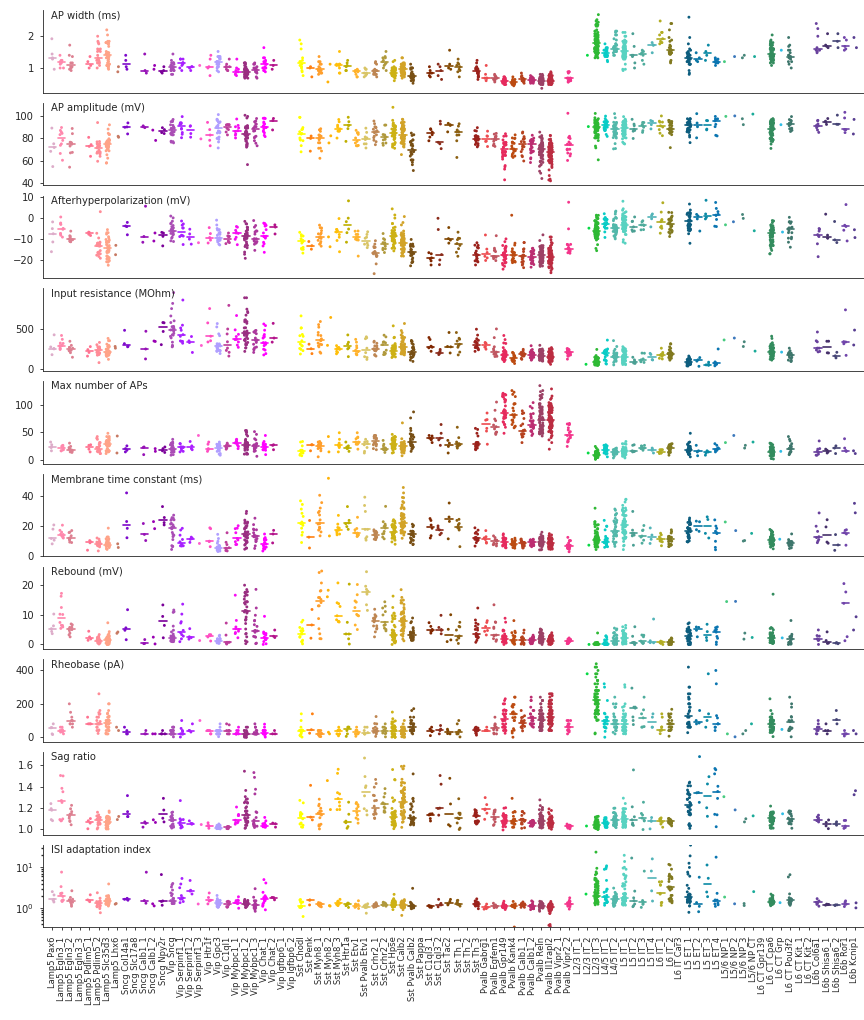

In [4]:
fig = plt.figure(figsize=(7.2, 8.5))

features_log = ['AP coefficient of variation', 'ISI coefficient of variation', 'ISI adaptation index',
                'AP Fano factor', 'ISI Fano factor', 'ISI average adaptation index', 
                'Latency (ms)', 'Latency @ +20pA current (ms)']

meaningfulFeatures = ['AP width (ms)', 'AP amplitude (mV)', 'Afterhyperpolarization (mV)', 
                      'Input resistance (MOhm)', 'Max number of APs', 'Membrane time constant (ms)',
                      'Rebound (mV)', 'Rheobase (pA)', 'Sag ratio', 'ISI adaptation index']
k = len(meaningfulFeatures)

for e in range(k):
    ax = plt.axes([.05,(k-e)/(k+1), .95, 1/(k+1)-.01])
    
    if m1.ephysNames[m1.ephysNames==meaningfulFeatures[e]] in features_log:
        plt.yscale('log')

    for t in range(clusterN):
        d = m1.ephys[(ttypes['m1consensus_ass']==t) & (m1.exclude==''),:][:,m1.ephysNames==meaningfulFeatures[e]]
        d = d[~np.isnan(d)]
        
        plt.scatter(t + np.random.uniform(-1,+1,size=d.size)/5, d, 
                    color=clusterColors[t], s=3, edgecolor='none')
        if d.size >= 3:
            plt.plot(t + np.array([-.4,.4]), np.array([1,1]) * np.median(d),
                     color=clusterColors[t], linewidth=1)
        
    if e==k-1:
        plt.xticks(range(clusterN), clusterNames, rotation=90, fontsize=5)
        plt.ylim([0.34,36])
    else:
        plt.xticks([])
    plt.xlim([-1, clusterN])
    plt.text(.01, .9, meaningfulFeatures[e], transform=ax.transAxes)

sns.despine()
plt.savefig('../figures/suppfigures/ephys-features.png', dpi=300)

In [5]:
%%time

# Make PDF with all features

features_log = ['AP coefficient of variation', 'ISI coefficient of variation', 'ISI adaptation index',
                'AP Fano factor', 'ISI Fano factor', 'ISI average adaptation index', 
                'Latency (ms)', 'Latency @ +20pA current (ms)']

perpage = 5

from matplotlib.backends.backend_pdf import PdfPages

plt.ioff()
with PdfPages('../figures/suppdocs/all-ephys-features.pdf') as pdf:
    for page in range(np.ceil(m1.ephys.shape[1]/perpage).astype(int)):
        plt.figure(figsize=(8.27, 11.69)) # A4
        for i in range(page*perpage, min((page+1)*perpage, m1.ephys.shape[1])):
            print('.', end='')
            plt.subplot(perpage, 1, i+1-page*perpage)
                       
            if m1.ephysNames[i] in features_log:
                plt.yscale('log')

            for t in range(clusterN):
                d = m1.ephys[(ttypes['m1consensus_ass']==t) & (m1.exclude==''),:][:,i]
                d = d[~np.isnan(d)]
        
                plt.scatter(t + np.random.uniform(-1,+1,size=d.size)/5, d, 
                            color=clusterColors[t], s=3, edgecolor='none')
                if d.size >= 3:
                    plt.plot(t + np.array([-.4,.4]), np.array([1,1]) * np.median(d),
                     color=clusterColors[t], linewidth=1)
        
            plt.xticks(range(clusterN), clusterNames, rotation=90, fontsize=5)
            plt.xlim([-1, clusterN])
            plt.title(m1.ephysNames[i])
        
        sns.despine()
        plt.tight_layout(rect=(.02,.02,.98,.98))
        pdf.savefig(dpi=400)
        plt.close() 
plt.ion()
print('')

.............................
CPU times: user 26.6 s, sys: 496 ms, total: 27.1 s
Wall time: 27.1 s
